<a href="https://colab.research.google.com/github/JuanBalde/Juan-y-Patricio-Facultad/blob/main/TP_8_Fotocromismo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import copy
from matplotlib.ticker import FuncFormatter

plt.rcParams["mathtext.fontset"]='dejavuserif'

In [ ]:
def Plot_CI(X:list,CI_lower:list,CI_upper:list,Color='gray',Transparencia=0.4,Label=''):
    """
    X : los X del array de intervalos de confianza
    CI_lower : El intervalo de confianza inferior
    CI_upper : El intervalo de confianza superior
    Color : opcional, color de relleno. Defaul= gris
    Transparecnia: opcional, default=0.4
    Label : opcional, etiqueta para legend
    """
    #plt.plot(X,CI_upper,color=Color)
    #plt.plot(X,CI_lower,color=Color)
    plt.fill_between(
        x=X,
        y1=CI_lower,
        y2=CI_upper,
        color=Color,
        alpha=Transparencia,
        label=Label
    )

def Residuo_stdr(y_exp,y_fit):
    """
    Calcula los residuos estandarizados
    Devuelve 2 np.arrays : ResStd y los "Outliers" (ResStd>2)
    ---------------------------------
    Param
    y_exp: los valores y experimentales
    y_fit: los valores de y ajustados para x esperimentales
    """
    residuo = y_exp-y_fit
    residuo_std = np.nanstd(residuo)
    residuo_standarizado = residuo/residuo_std

    return residuo_standarizado

## Resultados


## Modificar los valores de error para tiempos y absorbancia y Temperatura


In [ ]:
A = [# Absorbancia del maximo
    [
        249,245,241,240,236,232,228,223,220,215,211,205,201,196,191,187,182,179,174,
         170,166,163,160,156,153,150,147,144,141,139,136,134,131,129,127,125,123,121,
         119,118,116,114,112,111,109,108,107,105,104,103,102,101,100,99,98,97,96,96,
         94,93,92,92,91,90,89,89,88,88,87,87,86,86,85,85,85,84,84,83,83,83,83,82,82,
         82,81,81,81,81,80,80,80,80,80,79,79,79],
    [
        104,103,103,101,100,99,98,96,97,95,93,93,93,91,91,90,89,89,88,88,87,87,86,86,
        85,85,85,84,84,83,83,83,83,83,83,83,83,83,82,82,82,82,82,82,82,82,82,82
    ],
    [
        127,126,124,121,121,119,118,114,114,112,112,110,109,108,108,107,106,106,105,
        104,104,104,104,104,103,103,103,103,103,102,102
    ],
    [
        120,119,119,116,114,112,112,109,108,108,107,108,107,106,106,107,106,105,105,
        106,105,105,105
    ],
    [
        174,165,157,148,139,130,125,124,122,121,119,118,117,116,116,115,115,
        114,113,113,113,113,113,
    ],
    [
        213,213,218,210,208,205,201,196,197,189,184,180,177,169,167,161,159,154,150,
        147,143,140,137,133,131,129,127,124,124,123,120,120,119,117,117,117,116
    ]

]

A = [np.array(i)/1e3 for i in A]
A_outlier=copy.deepcopy(A)
#los "outliers los reemplazo por NAN y en las figuras abajo de los datos pongo los valores
# originales y solo donde hay un NAN se ve el original en rojo"
err_A=2e-3


Ainf = np.array([.039,.077,.083,.099,.107,.106])
A337 = np.array([.9828,1.09,1.226,1.231,1.326,1.310])



t = [np.arange(0,len(i)*20,20) for i in A ]
err_t = 4 #+/-4segundos
t[4] = list(range(0,7*20,20))
t[4] += list(range(t[4][-1]+10,t[4][-1]+(len(A[4])-6)*10,10))
t[4] = np.array(t[4])
t[5] = np.arange(0,len(A[-1])*5,5)

T = np.array([35, 40, 45, 50, 55, 60]) + 273    # k \ Temperatura de la medida
err_T = 0.01 + 273
err_T = np.array([err_T]*len(T))

In [ ]:
# Solo para ver mientras adquiriamos los datos

#for i in range(len(A)):
#    x=t[i]
#    print(i)
#    y=np.log(A[i]-Ainf[i])
#    plt.plot(x,y,".",label=f"T= {T[i]-273} C")
#    plt.ylabel("A")
#    plt.xlabel("t [s]")
#    plt.legend()
#    plt.show()

In [ ]:

##############################
#   OUTLIERS QUITADOS A MANO
###############################
    #AGREGAR A LA LISTA LOS INDEXES DE LOS PUNTOS A SACAR

# T= 35
outlier_index=[0,1,2,3]
for i in outlier_index:
    A[0][i]=np.nan
# T= 40
outlier_index=[0,8]
for i in outlier_index:
    A[1][i]=np.nan
# T= 45
outlier_index=[0,6]
for i in outlier_index:
    A[2][i]=np.nan
# T= 50
outlier_index=[2]
for i in outlier_index:
    A[3][i]=np.nan
# T= 55
outlier_index=[0]
for i in outlier_index:
    A[4][i]=np.nan
# T= 60
outlier_index=[0,1]
for i in outlier_index:
    A[5][i]=np.nan

## $\tau$ ajuste exponencial

<ipython-input-7-25d6212c5cbc>:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Temp Index de los outliers
35   [0 1 2 3]
40   [0 8]
45   [0 6]
50   [2]
55   [0]
60   [0 1]


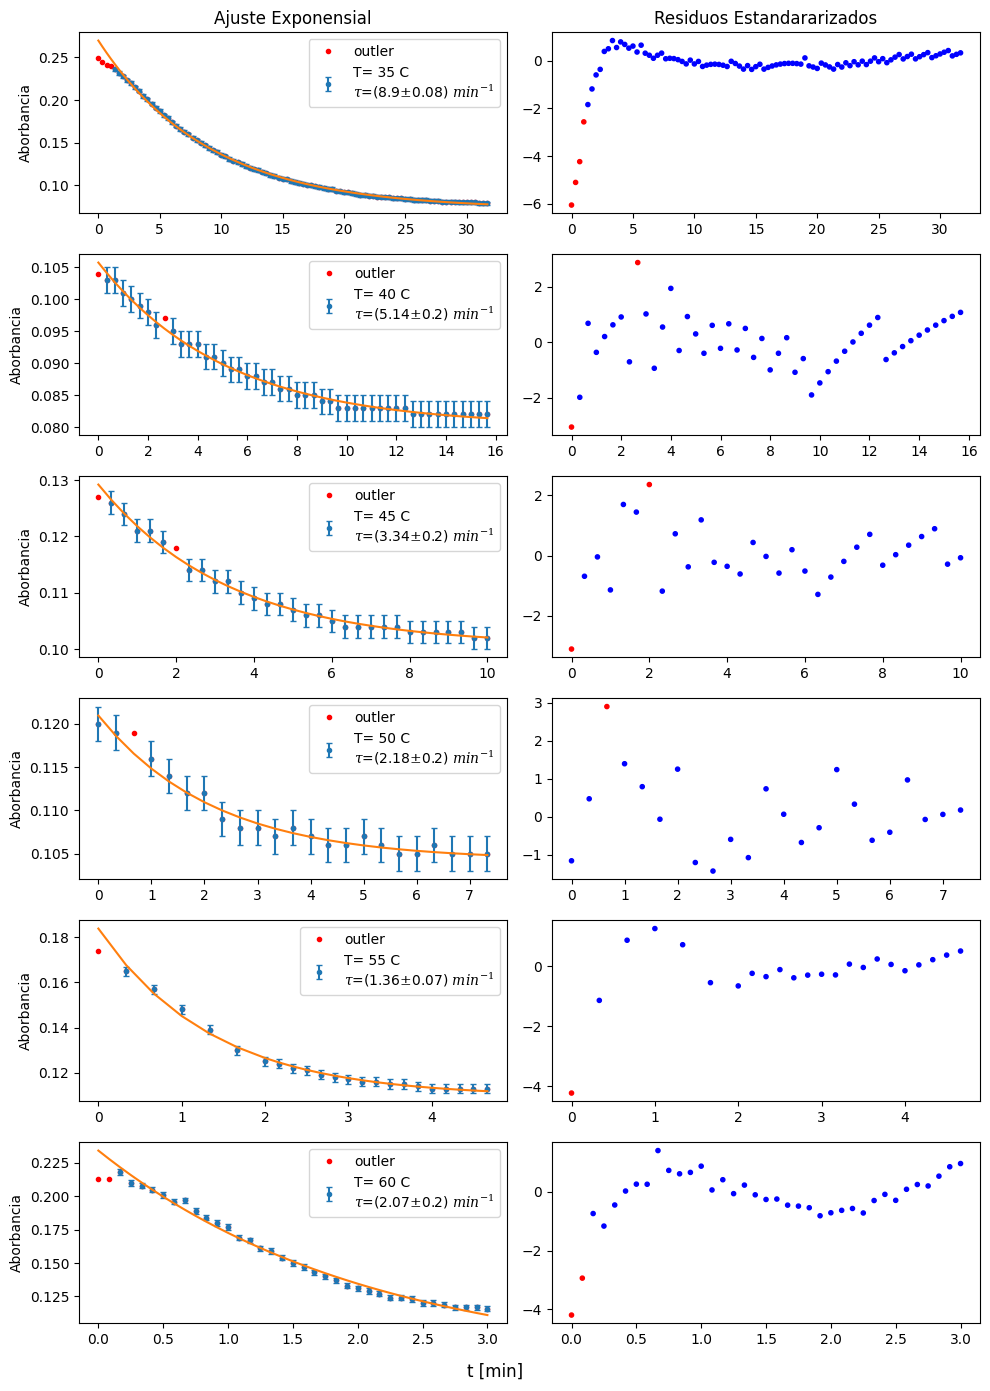

In [ ]:
def Exponencial(t,A,tau,inf):
    return (A/np.exp(t/tau))+inf

outlier_indexes=[] #index de los Res_standar>=2
Tau = np.array(list())
pre_exp =  np.array(list())
inf =  np.array(list())

err_Tau = np.array(list())
err_pre_exp = np.array(list())
err_inf = np.array(list())

fig,ax = plt.subplots(ncols=2,nrows=len(T),figsize=(10,14),layout='constrained')
for i in range(len(t)):
    # el total de los valores mededidos los llamo outlier, los grafico en rojo abajo de los valores
    # que usé para el ajuste. En los valores que uso para el ajusto reemplazo los outliers por NAN
    # entonces en el gráfico solo veo los rojos si el valor que use es un NAN
    x=t[i]/60
    y=A[i]
    yerr=[err_A]*len(y)
    y_outlier=A_outlier[i]

    ####################
    #   AJUSTE
    ####################

    param,covar=curve_fit(Exponencial,xdata=x,ydata=y,p0=(1,1,Ainf[i]),nan_policy='omit')
    errores=np.sqrt(np.diag(covar))

    _pre_exp,_tau,_inf=param
    _err_pre_exp,_err_tau,_err_inf=errores

    Tau=np.append(Tau,_tau)
    pre_exp=np.append(pre_exp,_pre_exp)
    inf=np.append(inf,_inf)

    err_Tau=np.append(err_Tau,_err_tau)
    err_pre_exp=np.append(err_pre_exp,_err_pre_exp)
    err_inf=np.append(inf,_err_inf)
    ####################
    #   GRAFICO
    ####################

    plt.sca(ax[i,0])
    plt.plot(x,y_outlier,"r.",label="outler")

    exp_label=f"T= {T[i]-273} C\n"+r"$\tau$"+f"=({_tau:.3g}"+r"$\pm$"+f"{_err_tau:.1g}) "+r"$min^{-1}$"
    plt.errorbar(x,y,yerr,capsize=2,fmt='.',label=exp_label,zorder=20)
    plt.plot(x,Exponencial(x,*param),zorder=21)
    plt.ylabel("Aborbancia")

    # RESIDUOS
    plt.sca(ax[i,1])
    res = Residuo_stdr(y_outlier,Exponencial(x,*param))
    colors = ['red' if abs(value) >= 2 else 'blue' for value in res]  #pinta de rojo res_stand>=2
    outlier_indexes.append(np.where(np.array(colors)=='red')[0]) #guarda los index de los rojos
    plt.scatter(x,res,color=colors,marker='.')

    ax[i,0].legend()

ax[0,0].set(title="Ajuste Exponensial")
ax[0,1].set(title="Residuos Estandararizados")

fig.supxlabel("t [min]")
plt.tight_layout()

plt.savefig("Datos.png",dpi=300,bbox_inches='tight')
print(f"{'Temp':<5}{'Index de los outliers':<8}")
for i in range(len(T)):
    print(f"{T[i]-273:<5}{outlier_indexes[i]}")


###############################################################################################
####    PARA QUE 1/EXP(t) NO DE ERROR DE OVERFLOW USÉ t EN MINUTOS, AHORA PASO TAU DE 1/MIN A 1/SEG
Tau = Tau/60
err_Tau = err_Tau/60

In [ ]:
dif_Ainf= 100*abs(Ainf-inf)/Ainf
print(f"{'Ainf exp':<10}{'Ainf ajuste':<10}{'diff %'}")
for i in range(len(A)):
    print(f"{Ainf[i]:<10.4g}{inf[i]:<10.4g}{dif_Ainf[i]:<4.1f}")

Ao_fit = pre_exp + inf
print(f"\n{'Ao':<10}{'Ainf ajuste':<10}{'diff %'}")
for i in range(len(A)):
    test_Ao=A[i]
    test_Ao=test_Ao[~np.isnan(test_Ao)]
    Ao_diff = 100*abs(test_Ao[0]-Ao_fit[i])/test_Ao[0]
    print(f"{test_Ao[0]:<10.4g}{Ao_fit[i]:<10.4g}{Ao_diff:.1f}")

Ainf exp  Ainf ajustediff %
0.039     0.07223   85.2
0.077     0.08018   4.1 
0.083     0.1006    21.2
0.099     0.1043    5.3 
0.107     0.1094    2.2 
0.106     0.0733    30.8

Ao        Ainf ajustediff %
0.236     0.2698    14.3
0.103     0.1057    2.6
0.126     0.1292    2.5
0.12      0.121     0.8
0.165     0.1838    11.4
0.218     0.2341    7.4


##$\tau$ linealizado **no lo usamos**
La reaccion es unimolecular de orden 1. Tenemos que comprobar que este es el caso.

$A(t) = (A_o - A_∞)e^{-t/\tau } + A_∞$

$\ln(A(t))=\ln(A_o)-t/\tau $

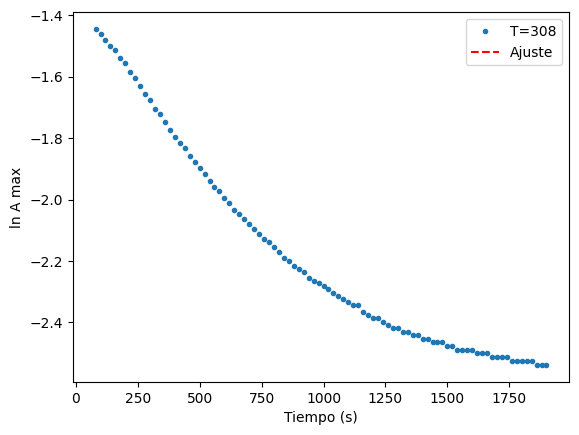

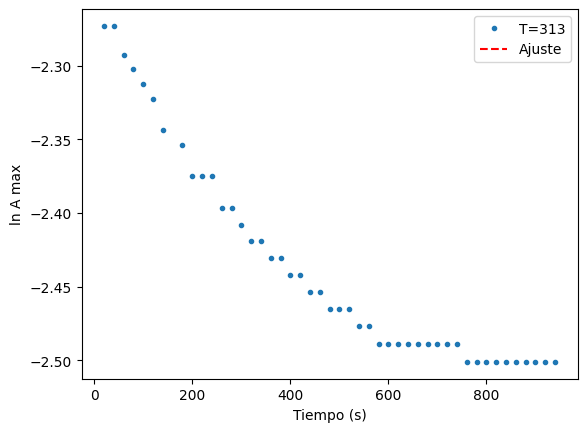

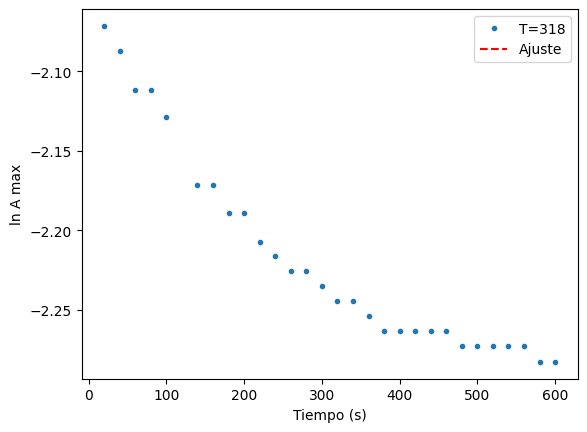

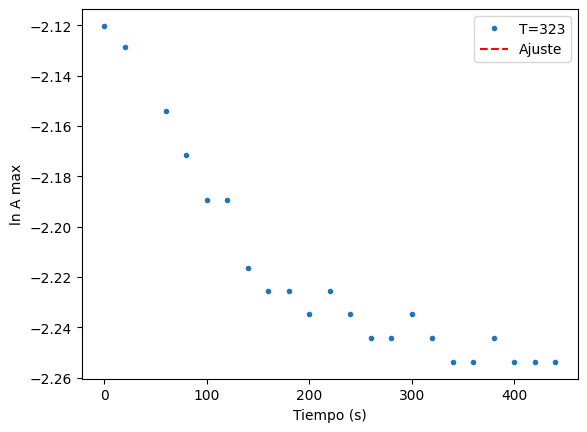

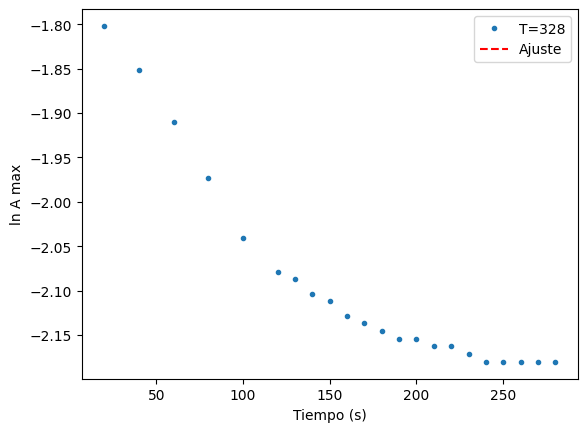

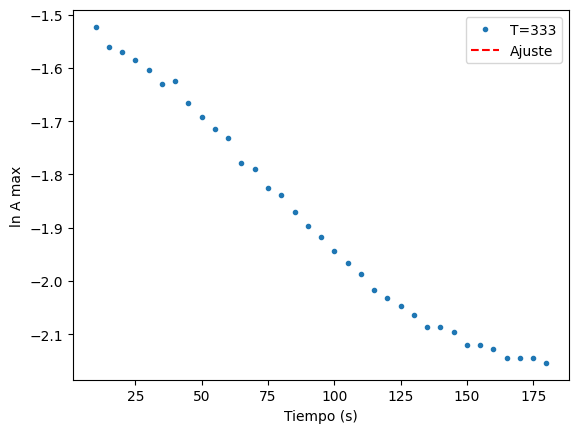

[0.14831205 0.08558758 0.05569862 0.0363907  0.02267925 0.0345369 ] +/- [0.0012642  0.00287903 0.00255356 0.0034668  0.00119062 0.00321393] 1/s


In [ ]:
for temp in range(len(T)):
    x = t[temp]
    y = np.log(A[temp])


    ajuste = sm.OLS(y,sm.add_constant(x)).fit()
    ord,pend = ajuste.params
    err_ord, err_pend = ajuste.bse
    r2 = ajuste.rsquared

    plt.plot(x, y, ".",label=f"T={T[temp]}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("ln A max")


    x_ci = np.linspace(x.min(),x.max(),50)
    frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.05)
    ci_low = frame.mean_ci_lower
    ci_up = frame.mean_ci_upper

    linea_x = np.array([x.min(),x.max()])
    plt.plot(linea_x,linea_x*pend+ord , 'r--',label = "Ajuste")
    Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)
    plt.legend()
    plt.show()

    #plt.savefig('Ajuste_Tau.png')
    #files.download('Ajuste_Tau.png')
#    Tau_ = 1/pend
#    err_Tau_ = 1/err_pend
#    Tau.append(Tau_)
#    err_Tau.append(err_Tau_)
#


Tau = np.array(Tau)
err_Tau = np.array(err_Tau)
print(f"{Tau} +/- {err_Tau} 1/s")

## Arrhenius

$\frac{1}{\tau}=Ae^{-E_a/RT}$

$\ln{\frac{1}{\tau}}=\ln{A}-E_a/RT$


Para obtener Tau use t en minutos

[$\tau$]=1/min--> divido por 60 para tenerlo en 1/seg

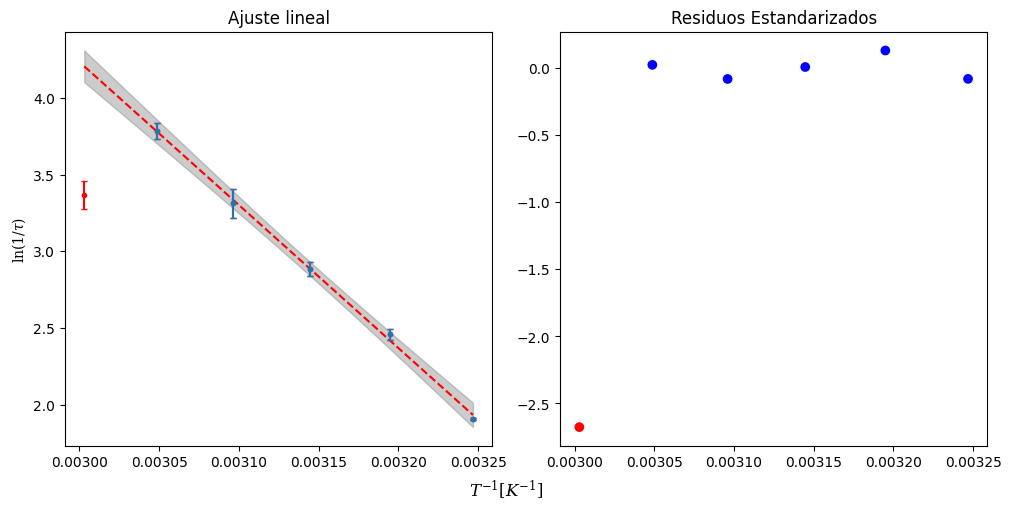


 %%%%%%%%%%%%%%%%%%%%
Ea = 77487.7 +/- 2e+03 J/mol  = 77.5 +/- 2 kJ/mol
ln(A) = 32.2 +/- 0.6
A = 95710344938434.8 +/- 2  1/min


In [ ]:
R = 8.31446261815324 # J/k mol

x = 1/T
y = np.log(1/Tau)
err_y = abs(-1/Tau)*err_Tau

ajuste = sm.OLS(y[:-1],sm.add_constant(x[:-1])).fit()
ord,pend = ajuste.params
err_ord, err_pend = ajuste.bse
r2 = ajuste.rsquared

fig,ax = plt.subplots(nrows=1,ncols=2,layout='constrained',sharex=True,figsize=(10,5))
plt.sca(ax[0])
plt.errorbar(x,y,yerr=err_y,fmt='.',capsize=2,zorder=8,c="r",label="outlier")
plt.errorbar(x[0:-1],y[0:-1],yerr=err_y[0:-1],fmt='.',capsize=2,zorder=10)
plt.ylabel(r"$\ln(1/\tau)$")


x_ci = np.linspace(x.min(),x.max(),50)
frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.05)
ci_low = frame.mean_ci_lower
ci_up = frame.mean_ci_upper

linea_x = np.array([x.min(),x.max()])
plt.plot(linea_x,linea_x*pend+ord , 'r--',label = "Ajuste")
Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)

plt.sca(ax[1])
Ea = -pend*R
err_Ea = abs(-R)*err_pend

pre_exp = np.exp(ord)
err_pre_exp = np.exp(err_ord)

res_est = Residuo_stdr(y_exp=y,y_fit=x*pend+ord)
colores=['red' if abs(i)>=2 else 'blue' for i in res_est]
plt.scatter(x,res_est,c=colores)

fig.supxlabel("$T^{-1} [K^{-1}]$")
ax[0].set_title("Ajuste lineal")
ax[1].set_title("Residuos Estandarizados")
plt.savefig('Cineticos.png')
plt.show()
print("\n","%"*20)
print(f"Ea = {Ea:.1f} +/- {err_Ea:.1g} J/mol  = {Ea/1000:.1f} +/- {err_Ea/1000:.1g} kJ/mol")
print(f"ln(A) = {ord:.1f} +/- {err_ord:.1g}")
print(f"A = {pre_exp:.1f} +/- {err_pre_exp:.1g}  1/min")

## Parametros termodinamicos
$\Delta H^{\neq} = E_a - RT$

$\Delta S^{\neq} = R\ln\left(\frac{Ah}{k_BTe}\right)$

H = 74.82 +/- 0.07 kJ/mol  con el errorbar:err=4
S = 13.83 +/- 0.2 J/k mol  con el errorbar:err=7
Ts = 4429.23 +/- 47 J/mol  con el errorbar:err=6e+03
G = 70.39 +/- 0.1 kJ/mol  con el errorbar:err=1e+01


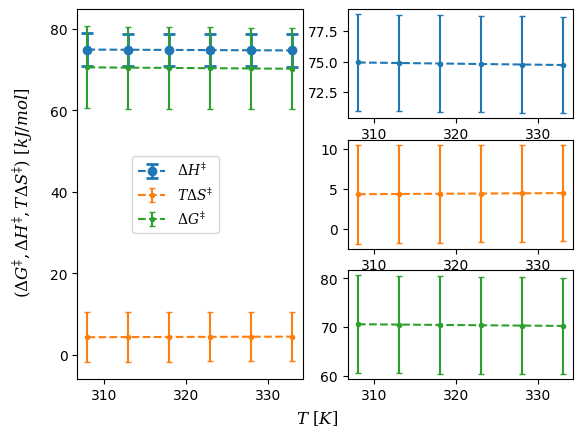

In [ ]:
H = Ea - R*T
err_H = err_Ea + R*err_T

h = 6.62607015*10**-34    # J/s \ Constante de Planck
k = 1.380649*10**-23      # J/k \ Constante de Boltzmann

S = R*np.log(pre_exp*h/(k*T*np.exp(1)))
err_S = abs(R/T)*err_T + abs(R/pre_exp)*err_pre_exp

Ts = T*S
err_Ts = abs(T)*err_S + abs(S)*err_T

G=H-Ts
err_G = err_H + err_Ts

############
## FIGURA
############

colores=plt.rcParams['axes.prop_cycle'].by_key()['color']

fig=plt.figure()
gs = plt.GridSpec(3,2)
#subplot(gs[row,col])
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,1])
plt.sca(ax1)
plt.errorbar(T,H/1000,yerr=err_H/1000,label=r"$\Delta H ^\ddag$",capsize=4,elinewidth=2,capthick=2,marker='o',linestyle="--",c=colores[0])
plt.errorbar(T,Ts/1000,yerr=err_Ts/1000,label=r"$T\Delta S ^\ddag$",capsize=2,marker='.',linestyle="--",c=colores[1])
plt.errorbar(T,G/1000,yerr=err_G/1000,label=r"$\Delta G ^\ddag$",capsize=2,marker='.',linestyle="--",c=colores[2])
plt.sca(ax2)
plt.errorbar(T,H/1000,yerr=err_H/1000,capsize=2,marker='.',linestyle="--",c=colores[0])
plt.sca(ax3)
plt.errorbar(T,Ts/1000,yerr=err_Ts/1000,capsize=2,marker='.',linestyle="--",c=colores[1])
plt.sca(ax4)
plt.errorbar(T,G/1000,yerr=err_G/1000,capsize=2,marker='.',linestyle="--",c=colores[2])
fig.legend(loc='lower left',bbox_to_anchor=(0.2,0.4))
fig.supylabel(r"$(\Delta G^\ddag,\Delta H^\ddag,T\Delta S^\ddag) \ [kJ/mol]$")
fig.supxlabel("$T\ [K]$")
plt.savefig('Termodinamicos.png',dpi=300,bbox_inches='tight')


print(f"H = {H.mean()/1000:.2f} +/- {H.std()/1000:.1g} kJ/mol  con el errorbar:err={err_H.mean()/1000:.1g}")
print(f"S = {S.mean():.2f} +/- {S.std():.1g} J/k mol  con el errorbar:err={err_S.mean():.1g}")
print(f"Ts = {Ts.mean():.2f} +/- {Ts.std():.2g} J/mol  con el errorbar:err={err_Ts.mean():.1g}")
print(f"G = {G.mean()/1000:.2f} +/- {G.std()/1000:.1g} kJ/mol  con el errorbar:err={err_G.mean()/1000:.1g}")

### Eyring

$\ln{\frac{k}{T}}=-\frac{\Delta^{\neq}H}{R}\frac{1}{T} + \frac{\Delta^{\neq}S}{R} + \ln{\frac{k_B}{h}}$

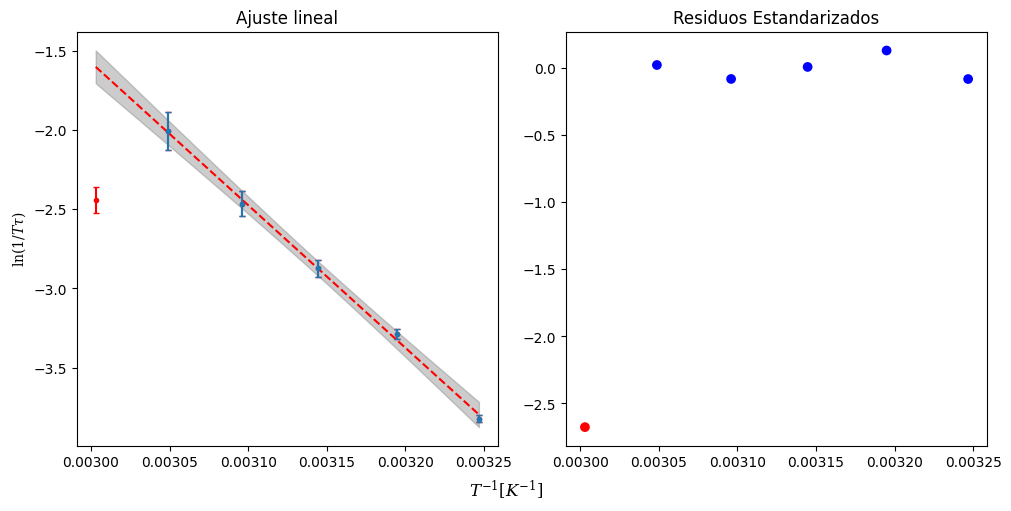

H_Eyring= 74.8 \pm 2 kJ/mol
S_Eyring= 13.9 \pm 5 J/K.mol


In [ ]:
h = 6.62607015*10**-34    # J/s \ Constante de Planck
k = 1.380649*10**-23      # J/k \ Constante de Boltzmann

x = 1/T
y = np.log(1/(T*Tau))
err_y = abs(-1/(T*(Tau**2)))*err_Tau+abs(-1/(Tau*(T**2)))*err_T

ajuste = sm.OLS(y[:-1],sm.add_constant(x[:-1])).fit()
ord,pend = ajuste.params
err_ord, err_pend = ajuste.bse
r2 = ajuste.rsquared

fig,ax = plt.subplots(nrows=1,ncols=2,layout='constrained',sharex=True,figsize=(10,5))
plt.sca(ax[0])
plt.errorbar(x,y,yerr=err_y,fmt='.',capsize=2,zorder=8,c="r",label="outlier")
plt.errorbar(x[0:-1],y[0:-1],yerr=err_y[0:-1],fmt='.',capsize=2,zorder=10)
plt.ylabel(r"$\ln(1/T\tau)$")


x_ci = np.linspace(x.min(),x.max(),50)
frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.05)
ci_low = frame.mean_ci_lower
ci_up = frame.mean_ci_upper

linea_x = np.array([x.min(),x.max()])
plt.plot(linea_x,linea_x*pend+ord , 'r--',label = "Ajuste")
Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)

plt.sca(ax[1])

H = -pend*R
err_H = abs(-R)*err_pend

S = R*(ord - np.log(k/h))
err_S = R*err_ord

res_est = Residuo_stdr(y_exp=y,y_fit=x*pend+ord)
colores=['red' if abs(i)>=2 else 'blue' for i in res_est]
plt.scatter(x,res_est,c=colores)

fig.supxlabel("$T^{-1} [K^{-1}]$")
ax[0].set_title("Ajuste lineal")
ax[1].set_title("Residuos Estandarizados")
plt.savefig('Eyring.png',dpi=300,bbox_inches='tight')
plt.show()

print(f"H_Eyring= {H/1000:.1f} \pm {err_H/1000:.1g} kJ/mol")
print(f"S_Eyring= {S:.1f} \pm {err_S:.1g} J/K.mol")

# Parametros cinéticos

dH cinetico= (10 \pm 5) kJ/mol


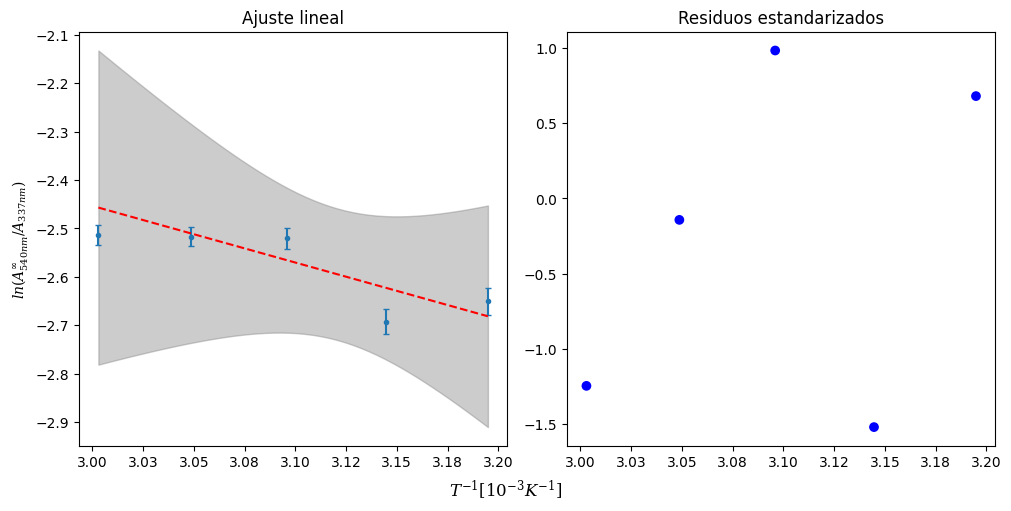

In [ ]:
y = np.log(Ainf[1:]/A337[1:])
err_y=err_A*(abs((1/Ainf[1:]))+abs(1/A337[1:]))
x = 1/T[1:]

ajuste = sm.OLS(y[:-1],sm.add_constant(x[:-1])).fit()
ord,pend = ajuste.params
err_ord, err_pend = ajuste.bse
r2 = ajuste.rsquared

x_ci = np.linspace(x.min(),x.max(),50)
frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.05)
ci_low = frame.mean_ci_lower
ci_up = frame.mean_ci_upper

######################################
#   FIGURA
######################################
linea_x = np.array([x.min(),x.max()])

fig,ax = plt.subplots(nrows=1,ncols=2,layout='constrained',sharex=True,figsize=(10,5))

plt.sca(ax[0])
plt.errorbar(x,y,yerr=err_y,capsize=2,fmt=" ",marker=".")
plt.plot(linea_x,linea_x*pend+ord , 'r--',label = "Ajuste")
Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)

plt.sca(ax[1])
res=Residuo_stdr(y,x*pend+ord)
colores=['red' if abs(i)>=2 else 'blue' for i in res]
plt.scatter(x,res,c=colores)

ax[0].set(ylabel="$ln(A^{\infty}_{540nm}/A_{337nm})$",title="Ajuste lineal")
ax[1].set(title="Residuos estandarizados")
# Define a formatter function
def thousands_formatter(x, pos):
    return f'{x*1000:.2f}'

# Apply the formatter to the x-axis and y-axis
for i in ax:
 i.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
#ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
fig.supxlabel("$T^{-1} [10^{-3} K^{-1}]$")
plt.savefig("Equilibrio.png",dpi=300,bbox_inches="tight")
Hcinetico=pend*(-R)
err_Hcinetico=abs(R)*err_pend
print(f"dH cinetico= ({Hcinetico/1000:.0f} \pm {err_Hcinetico/1000:.1g}) kJ/mol")


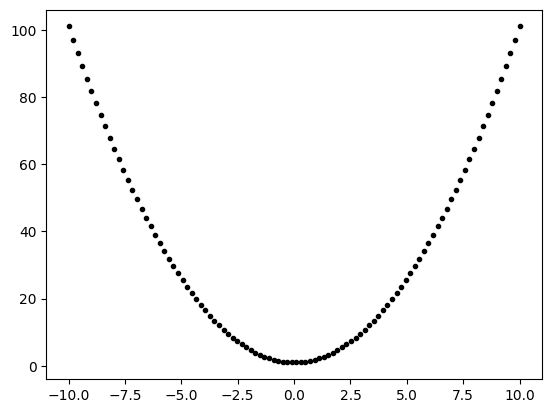

In [ ]:
x = np.linspace(-10,10,100)
y = (x**2 + 1)

plt.plot(x, y, 'k.')